# CSMODEL PHASE 1 - Froggers' Pokemon Analysis

![Tyranitar](assets/tyranitar.gif)![Scizor](assets/scizor.gif)![Keldeo](assets/keldeo.gif)![Terrakion](assets/terrakion.gif)![Jirachi](assets/jirachi.gif)![Latios](assets/latios.gif)

In [2]:
# Imports and Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as sp

## Chapter 1. Introduction

The nature of the data and the rationale behind its application will be discussed in this chapter. Information on how these data are gathered will also be addressed.

### 1.1 The Showdown Data set

The first and main dataset consists of records of a person's Pokemon battle. It specifically has columns of
* The battle's unique ID ("tag"), generated by Pokemon Showdown
* The name of the first player who participated in that battle (player 1)
* That player's elo ranking
* Which six Pokemon they used
* The lead Pokemon (which Pokemon they sent first)
* The turn count (how many turns the battle lasted)
* The result of that battle (win, lose, tie)

While a battle consists of two players each with their own unique features, we will delimit
our study to the scope of one person (player 1 only, and not player 2) and base our analyses from there.

This is because we mostly want to focus on identifying patterns on how a player builds their
teams given the meta irrespective of the other team. In Pokemon Showdown, teams are built
independently before players challenge each other and are not built "on the fly".

The specific data set we chose is matches done in the Generation 5 "Overused" format (Gen5OU). The reason
for this is this is the earliest version where the Pokemon Showdown implemented the feature where
you are able to see all of the opposing Pokemon from your opponent. This is important as it
enabled us to read the team composition of these matches.

#### 1.1.1 Scraping battle logs

Scraping the battle logs was done using a separate JavaScript program created by one of our
group members: [Showdown Scraper](https://github.com/jrgo7/showdown-scraper). Through this program, we were
able to **scrape the last 5000 recorded Gen5OU battles** from the Pokemon Showdown replay catalogue, which is all that
was available for this format. Unfortunately, this brings in a recency bias as we do not have access to the entire
population of Gen5OU Pokemon battles.

#### 1.1.2 Structuring battle logs

The battle logs by themselves are unstructured and are like chat messages in the sense that they are composed of lines
of "messages" that convey some information or action taken. A few examples:

```
|turn|1
```

represents the beginning of turn 1;

```
|poke|p1|Tyranitar, F|item
|poke|p1|Victini|item
|poke|p1|Excadrill, M|item
|poke|p1|Rotom-Wash|item
|poke|p1|Ferrothorn, F|item
|poke|p1|Latios, M|item
```

represents a definition of a set of 6 Pokemon for player 1 (the feature mentioned in section 1.1 which made us choose
this format in particular); and

```
|switch|p1a: Rotom|Rotom-Wash|100/100
```

represents that player 1 switched in ("sent out") the Pokemon named Rotom, who is currently at full HP (100/100).

These lines were parsed and processed into the [`showdown.csv`](./dataset/showdown/showdown.csv) file via the [`battlelogs_to_csv.py`](battlelogs_to_csv.py) script, containing the features mentioned in section 1.1.

In [3]:
showdown_df = pd.read_csv("./dataset/showdown/showdown.csv")
showdown_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Tag          5000 non-null   int64 
 1   Player       5000 non-null   object
 2   Elo          5000 non-null   int64 
 3   Pokemon 1    5000 non-null   object
 4   Pokemon 2    5000 non-null   object
 5   Pokemon 3    5000 non-null   object
 6   Pokemon 4    5000 non-null   object
 7   Pokemon 5    5000 non-null   object
 8   Pokemon 6    5000 non-null   object
 9   LeadPokemon  4987 non-null   object
 10  TurnCount    5000 non-null   int64 
 11  Result       5000 non-null   object
dtypes: int64(3), object(9)
memory usage: 468.9+ KB


In [4]:
for column in ["Player", *[f"Pokemon {i}" for i in range(1,7)], "LeadPokemon", "Result"]:
    showdown_df[column] = showdown_df[column].astype("str")
    
showdown_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Tag          5000 non-null   int64 
 1   Player       5000 non-null   object
 2   Elo          5000 non-null   int64 
 3   Pokemon 1    5000 non-null   object
 4   Pokemon 2    5000 non-null   object
 5   Pokemon 3    5000 non-null   object
 6   Pokemon 4    5000 non-null   object
 7   Pokemon 5    5000 non-null   object
 8   Pokemon 6    5000 non-null   object
 9   LeadPokemon  5000 non-null   object
 10  TurnCount    5000 non-null   int64 
 11  Result       5000 non-null   object
dtypes: int64(3), object(9)
memory usage: 468.9+ KB


#### 1.1.3 Ties

Matches do not always end in wins or losses; they can be ties, too.

In [5]:
showdown_df[showdown_df['Result'] == 'tie']

,Tag,Player,Elo,Pokemon 1,Pokemon 2,Pokemon 3,Pokemon 4,Pokemon 5,Pokemon 6,LeadPokemon,TurnCount,Result
387,1083803355,professorcaralho,1390,Politoed,Latios,Rotom-Wash,Breloom,Jirachi,Scizor,Rotom-Wash,30,tie
796,113898835,professorcaralho,1390,Politoed,Latios,Rotom-Wash,Breloom,Jirachi,Scizor,Rotom-Wash,30,tie
4803,93999693,Volta,1329,Dragonite,Keldeo,Scizor,Terrakion,Latios,Garchomp,Terrakion,27,tie
4807,94150142,Volta,1329,Dragonite,Keldeo,Scizor,Terrakion,Latios,Garchomp,Terrakion,27,tie


#### 1.1.4 Forfeit matches

Some records report no `LeadPokemon`. These indicate that the match ended
prematurely, before the player sent out a Pokemon in the first place, likely due
to disconnection issues or one of the players forfeit the match.

Nevertheless, data from "battles" like these can still be used to identify
trends in team building from people of different elo levels.

(I'm sure there are instances where we'd have to drop these though, as we
previously mentioned)

In [6]:
showdown_df[showdown_df["TurnCount"] == 0]

,Tag,Player,Elo,Pokemon 1,Pokemon 2,Pokemon 3,Pokemon 4,Pokemon 5,Pokemon 6,LeadPokemon,TurnCount,Result
69,101708749,WeForneMon,1660,Latios,Lucario,Gengar,Gastrodon,Heatran,Skarmory,nan,0,lose
377,1082937854,hgfjhds,1532,Tyranitar,Landorus-Therian,Rotom-Wash,Jirachi,Latios,Keldeo,nan,0,lose
798,1139401705,Wally,1653,Garchomp,Rotom-Wash,Tyranitar,Scizor,Latios,Terrakion,nan,0,win
811,1141004806,Wally,1653,Garchomp,Rotom-Wash,Tyranitar,Scizor,Latios,Terrakion,nan,0,win
1027,121892059,ALnlef,1307,Gliscor,Politoed,Rotom-Wash,Ferrothorn,Tentacruel,Tornadus,nan,0,lose
1307,2033253771,yusei38,1333,Politoed,Skarmory,Espeon,Kyurem-Black,Blissey,Jolteon,nan,0,win
1530,2058219606,yusei38,1333,Politoed,Skarmory,Espeon,Kyurem-Black,Blissey,Jolteon,nan,0,win
1667,2073047615,authentise_is_shit,1507,Politoed,Jellicent,Excadrill,Tornadus,Gastrodon,Ferrothorn,nan,0,lose
2283,2145224095,rabian,1345,Jolteon,Ferrothorn,Politoed,Gyarados,Toxicroak,Tentacruel,nan,0,lose
4052,588117142,Jack314,1314,Breloom,Garchomp,Latios,Jirachi,Rotom-Wash,Tyranitar,nan,0,lose


### 1.2 Generation 5 Base Stats

Species strengths, commonly referred to by fans as base stats (Japanese: 種族値 species values), are the inherent values of a species or form of a species that are used to the stats of a Pokémon (Bulbagarden). These statistics define a Pokemon's strength in that department, with 7 base stats affecting battle:\
- Health Points(HP) determines how much health a Pokemon has;
- Attack(ATK) determines how strong a Pokemon's physical moves are;
- Special Attack(SP ATK) determines how strong a Pokemon's special moves are;
- Defense(DEF) determines how resistant a Pokemon to physical moves are;
- Special Defense(SP DEF) determines how resistant a Pokemon to special moves are;
- Speed (SPD) determines how fast a Pokemon is, in context of a match will let a Pokemon move first on a turn.

This data set is used in addition to the Showdown matches to give some depth to the information with the inclusion of base stats since these greatly affect battle outcomes. This data set is gathered in the Bulbagarden website through this link: [Pokemon Generation II-V Stats)](https://m.bulbapedia.bulbagarden.net/wiki/List_of_Pokémon_by_base_stats_(Generation_II-V))

In [7]:
#Importing Generation 5 base stats data set
gen5_stats_df = pd.read_csv(r"dataset/bulbagarden/pokemon_gen5_stats.csv")
gen5_stats_df

,Pokedex number,Name,HP,Attack,Special Attack,Defense,Special Defense,Speed,Stat total,Stat average
0,1,Bulbasaur,45,49,49,65,65,45,318,53.00
1,2,Ivysaur,60,62,63,80,80,60,405,67.50
2,3,Venusaur,80,82,83,100,100,80,525,87.50
3,4,Charmander,39,52,43,60,50,65,309,51.50
4,5,Charmeleon,58,64,58,80,65,80,405,67.50
...,...,...,...,...,...,...,...,...,...,...
665,647,Keldeo,91,72,90,129,90,108,580,96.67
666,647,Keldeo-Resolute,91,72,90,129,90,108,580,96.67
667,648,Meloetta,100,77,77,128,128,90,600,100.00
668,648,Meloetta-Pirouette,100,128,90,77,77,128,600,100.00


In [8]:
gen5_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670 entries, 0 to 669
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Pokedex number   670 non-null    int64  
 1   Name             670 non-null    object 
 2   HP               670 non-null    int64  
 3   Attack           670 non-null    int64  
 4   Special Attack   670 non-null    int64  
 5   Defense          670 non-null    int64  
 6   Special Defense  670 non-null    int64  
 7   Speed            670 non-null    int64  
 8   Stat total       670 non-null    int64  
 9   Stat average     670 non-null    float64
dtypes: float64(1), int64(8), object(1)
memory usage: 52.5+ KB


### 1.3 Pokemon Types

The types of pokemon are essential in team building as the pokemon's types dictate to which other types a pokemon is weak to and which moves would be more potent for that pokemon to use. 

The types however, were changed during two instances of the entire pokemon franchise which is during Generation 2 with the introduction of dark and steel and at generation 6 with the introduction of fairy. 

Since the analysis only focuses on the format of Generation 5 Overused, the types will be only updated as of Generation 2. The data is gathered from the pokemon fandom website with the following links: 

- [Generation 1 Pokemon Types](https://pokemon.fandom.com/wiki/List_of_Generation_I_Pokémon)

- [Generation 2 Pokemon Types](https://pokemon.fandom.com/wiki/List_of_Generation_II_Pokémon)

- [Generation 3 Pokemon Types](https://pokemon.fandom.com/wiki/List_of_Generation_III_Pokémon)

- [Generation 4 Pokemon Types](https://pokemon.fandom.com/wiki/List_of_Generation_IV_Pokémon)

- [Generation 5 Pokemon Types](https://pokemon.fandom.com/wiki/List_of_Generation_V_Pokémon)

In each generation, the References section is used to correct the typings of the pokemon to fit the fifth generation of games. The data is gathered through copying the table data into a spreadsheet and saving it as a csv after the type correction is applied. The format of this data set follows a table with each row representing a pokemone with its name, first typing and second typing.



In [9]:
gen5_types_df = pd.read_csv("./dataset/pokemon-fandom/pokemon_gen5_types.csv")
gen5_types_df

,#,Name,Type 1,Type 2
0,1,Bulbasaur,Grass,Poison
1,2,Ivysaur,Grass,Poison
2,3,Venusaur,Grass,Poison
3,4,Charmander,Fire,NaN
4,5,Charmeleon,Fire,NaN
...,...,...,...,...
646,645,Landorus,Ground,Flying
647,646,Kyurem,Dragon,Ice
648,647,Keldeo,Water,Fighting
649,648,Meloetta,Normal,Psychic


In [10]:
gen5_types_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651 entries, 0 to 650
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   #       651 non-null    int64 
 1   Name    651 non-null    object
 2   Type 1  651 non-null    object
 3   Type 2  297 non-null    object
dtypes: int64(1), object(3)
memory usage: 20.5+ KB


### 1.4 Smogon Stats

Lastly, the smogon statistics will be included. This data set details different summarized statistics regarding Pokemon beginning at November of 2014. These statistics are logged by the Poekmon Showdown site owners and are summarized monthly. Notable statistics regarding this would be the Pokemon's usage statistics, the build and moveset of the Pokemon and even descriptions regarding a match called the metagame such as pressence of weather effects and the stalliness of a game. This data set's structure is in a table format with each row being a unique pokemon and the columns as the usage statistics such as usage %, raw usage, real % and real usage.

In [11]:
gen5ou_2015 = pd.read_csv("./dataset/smogon/2015-01-gen5ou-0.csv")
gen5ou_2015.columns = [
    col if col == 'Pokemon' else f"{col}_2015"
    for col in gen5ou_2015.columns
]
gen5ou_2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Rank_2015    380 non-null    int64 
 1   Pokemon      380 non-null    object
 2   Usage%_2015  380 non-null    object
 3   Raw_2015     380 non-null    int64 
 4   %_2015       380 non-null    object
 5   Real_2015    380 non-null    int64 
 6   %.1_2015     380 non-null    object
dtypes: int64(3), object(4)
memory usage: 20.9+ KB


In [12]:
gen5ou_2025 = pd.read_csv("./dataset/smogon/2025-01-gen5ou-0.csv")
gen5ou_2025.columns = [
    col if col == 'Pokemon' else f"{col}_2025"
    for col in gen5ou_2025.columns
]
gen5ou_2025.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Rank_2025    476 non-null    int64 
 1   Pokemon      476 non-null    object
 2   Usage%_2025  476 non-null    object
 3   Raw_2025     476 non-null    int64 
 4   %_2025       476 non-null    object
 5   Real_2025    476 non-null    int64 
 6   %.1_2025     476 non-null    object
dtypes: int64(3), object(4)
memory usage: 26.2+ KB


In [13]:
gen5ou_usage = pd.merge(gen5ou_2015, gen5ou_2025, on='Pokemon', how='outer')
gen5ou_usage

,Rank_2015,Pokemon,Usage%_2015,Raw_2015,%_2015,Real_2015,%.1_2015,Rank_2025,Usage%_2025,Raw_2025,%_2025,Real_2025,%.1_2025
0,62.0,Abomasnow,2.18801%,81.0,2.188%,72.0,2.478%,37.0,3.97171%,3409.0,3.972%,2979.0,4.382%
1,266.0,Abra,0.05402%,2.0,0.054%,2.0,0.069%,NaN,NaN,NaN,NaN,NaN,NaN
2,173.0,Absol,0.24311%,9.0,0.243%,8.0,0.275%,176.0,0.18641%,160.0,0.186%,130.0,0.191%
3,291.0,Accelgor,0.05402%,2.0,0.054%,2.0,0.069%,169.0,0.20855%,179.0,0.209%,149.0,0.219%
4,74.0,Aerodactyl,1.70178%,63.0,1.702%,57.0,1.962%,76.0,1.21050%,1039.0,1.211%,968.0,1.424%
...,...,...,...,...,...,...,...,...,...,...,...,...,...
506,NaN,Zigzagoon,NaN,NaN,NaN,NaN,NaN,435.0,0.00233%,2.0,0.002%,1.0,0.001%
507,82.0,Zoroark,1.43166%,53.0,1.432%,18.0,0.620%,86.0,1.01361%,870.0,1.014%,289.0,0.425%
508,256.0,Zorua,0.05402%,2.0,0.054%,0.0,0.000%,434.0,0.00233%,2.0,0.002%,0.0,0.000%
509,360.0,Zubat,0.02701%,1.0,0.027%,1.0,0.034%,NaN,NaN,NaN,NaN,NaN,NaN


⚠ This data set will not be used as of the writting of this notebook(Phase 1) and will be subsequently utilized in future analysis.

## Chapter 2. Research Questions and EDA's

### 2.1 Main Research Question

<p align="center">
  <em><span style="font-size: 20px;">
    What patterns in team building, metagame trends, and strategic preferences can be observed from Gen 5 OU Pokémon match data?
  </span></em>
</p>

### 2.2 EDA's

#### 2.2.1 What is the distribution of base stats among teams, and are they Correlated?
Different Pokemon have different stats, and we would like to figure out what stats are correlated with one another to determine the relationships between different stats. 

This goes the same way for the way each player may build their team. We can investigate the how each team statistic (average of each of the pokemon's specific stat) and determine if there are relationships or not.

#### 2.2.2 Which Pokemon is generally more favored to go first other than the rest? What is their stat distribution?
The lead Pokemon of a team can set the pace of a match. Because of this, the choice of which Pokemon to send out is very important to a player. We would like to see which Pokemon is preferred by most people to send out first.

#### 2.2.3 Are battles done quicker by players with a higher skill level(ELO)?
More skilled players, assumed to be those who have a higher ELO in the rating system, likely understand the game better than beginners and can play more optimally. Knowing this, we would like to know if there is a correlation between the ELO of players and how fast they are able to finish the game.

#### 2.2.4 What are the types that are usually run on competitive Pokemon Teams?
Because of the typing mechanic of Pokemon, each with their specific strenghts and weaknesses, it is understandable if some types are preferred over others. We would like to know what these types are.

## Chapter 3. Data Pre-processing

#### This chapter focuses on the operations done to the data sets in order to tailor it for our analysis.

### 3.1 Data Cleaning

#### 3.1.1 Duplicate players

After formatting the columns, we have realized that while all the matches 
are different, multiple battles from the same players have been collected.

As we can see, some players prefer to use the exact same team composition
using the same Pokemon in different battles. This would lead to bias to
certain Pokemon and team compositions in general, as a player's reference
does not necessarily correlate with the actual meta determined by the community.

In order to not skew the data to the preferences/team-building of some players,
we have chosen to drop these duplicate players in order to get a better view of
the community.

In [14]:
team_cols = ["Player"] + [f"Pokemon {i}" for i in range(1, 7)]
showdown_df[showdown_df.duplicated(subset=team_cols, keep=False)].sort_values(by="Player")

,Tag,Player,Elo,Pokemon 1,Pokemon 2,Pokemon 3,Pokemon 4,Pokemon 5,Pokemon 6,LeadPokemon,TurnCount,Result
4852,95498129,(LoD)Marcos,1444,Gengar,Volcarona,Salamence,Jirachi,Mienshao,Scrafty,Gengar,37,lose
4847,95190427,(LoD)Marcos,1392,Gengar,Volcarona,Salamence,Jirachi,Mienshao,Scrafty,Gengar,18,win
1717,2080451177,123perejil123,1325,Tyranitar,Landorus-Therian,Excadrill,Clefable,Latios,Slowbro,Latios,2,win
1647,2069514743,123perejil123,1325,Tyranitar,Landorus-Therian,Excadrill,Clefable,Latios,Slowbro,Latios,2,win
3288,2293763103,133fcsq,1464,Politoed,Keldeo,Latios,Starmie,Thundurus-Therian,Jirachi,Keldeo,25,win
...,...,...,...,...,...,...,...,...,...,...,...,...
1138,171229752,yusei38,1268,Politoed,Skarmory,Espeon,Kyurem-Black,Blissey,Jolteon,Jolteon,21,win
3827,2363527686,zerqaq,1368,Landorus-Therian,Politoed,Starmie,Ferrothorn,Jirachi,Latios,Politoed,16,win
3826,2363486536,zerqaq,1347,Landorus-Therian,Politoed,Starmie,Ferrothorn,Jirachi,Latios,Landorus-Therian,28,win
71,101724423,Śhofũ,1434,Politoed,Chansey,Skarmory,Tentacruel,Celebi,Tangrowth,Chansey,148,win


In [15]:
showdown_df = showdown_df.drop_duplicates(subset="Player", keep="first")
showdown_df

,Tag,Player,Elo,Pokemon 1,Pokemon 2,Pokemon 3,Pokemon 4,Pokemon 5,Pokemon 6,LeadPokemon,TurnCount,Result
0,1000949555,HaxerShouldAllDie,1444,Infernape,Breloom,Tyranitar,Jellicent,Bronzong,Reuniclus,Infernape,24,lose
2,100157536,BigBadLeroyBrown,1306,Tyranitar,Alakazam,Latios,Ferrothorn,Landorus-Therian,Excadrill,Tyranitar,31,win
3,1001647389,testing4g4in,1488,Tyranitar,Amoonguss,Starmie,Alakazam,Heatran,Skarmory,Starmie,22,lose
4,100171063,bossaru2,1377,Tyranitar,Stoutland,Forretress,Salamence,Gliscor,Breloom,Breloom,24,lose
5,100192677,jo0n vo0ight,1312,Tornadus,Politoed,Tentacruel,Dugtrio,Ferrothorn,Jirachi,Tornadus,22,lose
...,...,...,...,...,...,...,...,...,...,...,...,...
4981,991306568,shiny peoples,1304,Politoed,Amoonguss,Excadrill,Thundurus-Therian,Keldeo,Ferrothorn,Politoed,22,lose
4983,99232112,My Nostalgic Past,1268,Politoed,Gyarados,Jolteon,Ferrothorn,Haxorus,Umbreon,Politoed,71,win
4987,99352898,Sneakypanda,1393,Scizor,Togekiss,Hippowdon,Infernape,Terrakion,Sableye,Infernape,25,lose
4988,993678093,Caster33,1287,Tyranitar,Garchomp,Heatran,Conkeldurr,Forretress,Jellicent,Garchomp,14,win


#### 3.1.2 Pokemon's Multiple Forms

Some Pokémon possess multiple forms, each with distinct base stats and typings, and these forms are often notated differently within the dataset. To ensure accuracy and consistency, we carefully reviewed the datasets manually and corrected the entries so that each form is properly represented with its unique base stats and typings. This process helps prevent data inconsistencies and ensures that analyses reflect the true characteristics and potential of each Pokémon form, rather than treating them as a single, generic entity. As a result, our dataset provides a more precise and reliable foundation for any subsequent analysis or modeling.

<p align="center">
<a href="https://pokemondb.net/pokedex/wormadam"><img src="https://img.pokemondb.net/sprites/black-white/anim/normal/wormadam-plant.gif" alt="Wormadam" style="width: 150px;"></a>
<a href="https://pokemondb.net/pokedex/wormadam"><img src="https://img.pokemondb.net/sprites/black-white/anim/normal/wormadam-sandy.gif" alt="Wormadam" style="width: 150px;"></a>
<a href="https://pokemondb.net/pokedex/wormadam"><img src="https://img.pokemondb.net/sprites/black-white/anim/normal/wormadam-trash.gif" alt="Wormadam" style="width: 150px;"></a>
  <br>
  <em><b>Figure 1.</b> Different Wormadam Forms</em>
</p>

In [16]:
gen5_types_df.drop('#', axis=1, inplace=True)

In [17]:
gen5_consolidated_df = pd.merge(gen5_types_df, gen5_stats_df, on='Name', how='outer')
gen5_consolidated_df[gen5_consolidated_df['Type 1'].isna()]

,Name,Type 1,Type 2,Pokedex number,HP,Attack,Special Attack,Defense,Special Defense,Speed,Stat total,Stat average
114,Darmanitan-Zen,NaN,NaN,555,105,30,105,140,105,55,540,90.00
121,Deoxys-Attack,NaN,NaN,386,50,180,20,180,20,150,600,100.00
122,Deoxys-Defense,NaN,NaN,386,50,70,160,70,160,90,600,100.00
123,Deoxys-Speed,NaN,NaN,386,50,95,90,95,90,180,600,100.00
196,Gastrodon-East,NaN,NaN,423,111,83,68,92,82,39,475,79.17
204,Giratina-Origin,NaN,NaN,487,150,120,100,120,100,90,680,113.33
274,Keldeo-Resolute,NaN,NaN,647,91,72,90,129,90,108,580,96.67
289,Kyurem-Black,NaN,NaN,646,125,170,100,120,90,95,700,116.67
290,Kyurem-White,NaN,NaN,646,125,120,90,170,100,95,700,116.67
294,Landorus-Therian,NaN,NaN,645,89,145,90,105,80,91,600,100.00


From the results of the code we can see several Pokemon without a type and this is because the data from Pokemon-Fandom does not include these types, as such these will be modified manually in the file  `pokemon_gen5_types.csv` to accomodate for the missing typing.

In [18]:
gen5_types_df = pd.read_csv("./dataset/pokemon-fandom/pokemon_gen5_types_fixed.csv")
gen5_types_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670 entries, 0 to 669
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   #       670 non-null    int64 
 1   Name    670 non-null    object
 2   Type 1  670 non-null    object
 3   Type 2  312 non-null    object
dtypes: int64(1), object(3)
memory usage: 21.1+ KB


In [19]:
multiple_form_pokemon = [
    "Darmanitan-Zen", "Deoxys-Attack", "Deoxys-Defense", "Deoxys-Speed",
    "Gastrodon-East", "Giratina-Origin", "Keldeo-Resolute", "Kyurem-Black", "Kyurem-White",
    "Landorus-Therian", "Meloetta-Pirouette", "Rotom-Fan", "Rotom-Frost", "Rotom-Heat",
    "Rotom-Mow", "Rotom-Wash", "Shaymin-Sky", "Thundurus-Therian", "Tornadus-Therian",
    "Wormadam-Sandy", "Wormadam-Trash"
]
gen5_types_df[gen5_types_df['Name'].isin(multiple_form_pokemon)]

,#,Name,Type 1,Type 2
386,386,Deoxys-Attack,Psychic,NaN
387,386,Deoxys-Defense,Psychic,NaN
388,386,Deoxys-Speed,Psychic,NaN
416,413,Wormadam-Sandy,Bug,Ground
417,413,Wormadam-Trash,Bug,Steel
428,423,Gastrodon-East,Water,Ground
485,479,Rotom-Fan,Electric,Flying
486,479,Rotom-Frost,Electric,Ice
487,479,Rotom-Heat,Electric,Fire
488,479,Rotom-Mow,Electric,Grass


### 3.2 Feature Engineering

#### 3.2.1 Base Stats

In the data set, each team consists of 6 Pokémon, which makes it challenging to represent the individual statistics of every team member. To address this, the base stats of all Pokémon on a team are aggregated and represented as the average of the team's base stats, providing a more manageable and holistic view of team strength. Additionally, the base stat of the lead Pokémon—the one that starts the battle—is specifically logged in the data set, allowing for more detailed analysis of how the lead's attributes may influence team performance or battle outcomes. This approach ensures both team-wide and individual lead insights are captured for more comprehensive analysis.

In [20]:
stats = ['HP', 'Attack', 'Special Attack', 'Defense', 'Special Defense', 'Speed']

#Create Columns
for stat in stats:
    showdown_df[f'Avg_{stat}'] = 0.0

for row in showdown_df.itertuples():
    pkmn_name = showdown_df.at[row.Index, f"LeadPokemon"]
    #Checks for "nan" since column is stringified
    if (pkmn_name != "nan"):
        #Takes base stat from gen5_stats_df to Lead pokemon stats
        for stat in stats:
            leadStat = gen5_stats_df.loc[gen5_stats_df['Name'] == pkmn_name, stat].values[0]
            showdown_df.at[row.Index, f'Lead_{stat}'] = leadStat
    
    #Iterates over every pokemon in the team then every stat, for the average stat
    for i in range(1, 7):
        pkmn_name = showdown_df.at[row.Index, f"Pokemon {i}"]
        for stat in stats:
            stat_point = gen5_stats_df.loc[gen5_stats_df['Name'] == pkmn_name, stat].values[0]
            showdown_df.at[row.Index, f'Avg_{stat}'] += stat_point / 6

#### 3.2.2 Pokemon Types in teams

Types are important in teambuilding as they dictate the coverage, strengths, and weaknesses of a team. To capture this aspect, a feature was engineered as a boolean value indicating whether a team contains at least one Pokémon of a given type. This allows for quick assessment of type diversity within teams, which can be crucial for both offensive and defensive strategies.

In [21]:
types = ['Normal', 'Fighting','Flying','Poison','Ground','Rock','Bug','Ghost','Steel',
         'Fire','Water','Grass','Electric','Psychic','Ice','Dragon','Dark'
]

#Create Columns
for type in types:
    showdown_df[f'Has_{type}'] = False

for row in showdown_df.itertuples():
    for i in range(1, 7):
        pkmn_name = showdown_df.at[row.Index, f"Pokemon {i}"]
        
        type_1 = gen5_types_df.loc[gen5_types_df['Name'] == pkmn_name, 'Type 1'].values[0]
        type_2 = gen5_types_df.loc[gen5_types_df['Name'] == pkmn_name, 'Type 1'].values[0]
        
        showdown_df.at[row.Index, f"Has_{type_1}"] = True
        if(pd.notna(type_2)):
            showdown_df.at[row.Index, f"Has_{type_2}"] = True

#### 3.2.3 Unique Pokemons in the Team



In [22]:
# unique_pokemon_df = 

# for row in showdown_df.itertuples():
#     for i in range(1, 7):
#         pkmn_name = showdown_df.at[row.Index, f"Pokemon {i}"]
        
#         showdown_df.at[row.Index, f"Has_{type_1}"] = True
#         if(pd.notna(type_2)):
#             showdown_df.at[row.Index, f"Has_{type_2}"] = True

unique_pokemons = pd.DataFrame({})
for i in range(1, 7):
    unique_pokemons = pd.concat([unique_pokemons, pd.DataFrame(showdown_df[f"Pokemon {1}"].unique())])
unique_pokemons[0].unique()

array(['Infernape', 'Tyranitar', 'Tornadus', 'Gengar', 'Toxicroak',
       'Skarmory', 'Victini', 'Hippowdon', 'Garchomp', 'Jellicent',
       'Politoed', 'Breloom', 'Ninetales', 'Bronzong', 'Alakazam',
       'Chansey', 'Latios', 'Rotom-Wash', 'Ferrothorn',
       'Landorus-Therian', 'Scizor', 'Cofagrigus', 'Mamoswine', 'Lucario',
       'Feraligatr', 'Dragonite', 'Aerodactyl', 'Latias', 'Slaking',
       'Floatzel', 'Amoonguss', 'Azelf', 'Heatran', 'Abomasnow', 'Espeon',
       'Thundurus-Therian', 'Terrakion', 'Porygon2', 'Keldeo',
       'Volcarona', 'Bisharp', 'Celebi', 'Jirachi', 'Kyurem-Black',
       'Excadrill', 'Rhyperior', 'Reuniclus', 'Magnezone', 'Umbreon',
       'Articuno', 'Froslass', 'Cloyster', 'Starmie', 'Tentacruel',
       'Metagross', 'Yanmega', 'Staraptor', 'Gliscor', 'Hydreigon',
       'Forretress', 'Salamence', 'Seismitoad', 'Gyarados',
       'Keldeo-Resolute', 'Blissey', 'Venusaur', 'Haxorus', 'Golurk',
       'Virizion', 'Nidoking', 'Weavile', 'Electrode', 

### 3.3 Finalized Showdown Data set

We save the showdown data frame as a new csv so as to not repeat the pre-processing done to the data set.

In [ ]:
#Save data set to showdown.csv
showdown_df.to_csv('showdown.csv', index=False)
unique_pokemons.to_csv('unique_pokemons.csv', index=False)
gen5ou_usage.to_csv('gen5ou_usage.csv', index=False)



<p align="center">
  <img src="assets/pokemon-center.gif" alt="PKCenter" width="200"/>
</p>

Running the notebook starting from the following code will skip the pre-processing while retaining the cleaned data-set

In [24]:
# Checkpoint to begin loading the Showdown data set

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as sp

gen5_types_df = pd.read_csv("./dataset/pokemon-fandom/pokemon_gen5_types_fixed.csv")
gen5_stats_df = pd.read_csv(r"dataset/bulbagarden/pokemon_gen5_stats.csv")
showdown_df = pd.read_csv("showdown.csv")
unique_pokemons_df = pd.read_csv("unique_pokemons.csv")
gen5ou_usage_df = pd.read_csv("gen5ou_usage.csv")

## Chapter 4. Exploratory Data Analysis

### 4.1 Base Stats

#### 4.1.1 Distribution of Average Base Stats in Pokemon Teams

Each team is made up of 6 different Pokemon with their own stats. Getting
the average stats of a team can show us what different people prioritize
in building their Pokemon team.

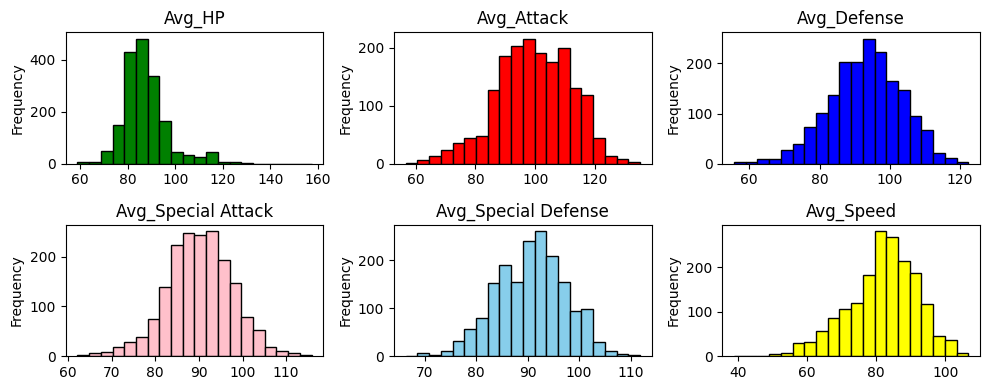

In [145]:
fig, ax = plt.subplots(2, 3, figsize=(10, 4))

ax[0,0].hist(showdown_df['Avg_HP'].dropna(),bins=20, color='green', edgecolor='black')
ax[0,0].set_title('Avg_HP')
ax[0,0].set_ylabel('Frequency')

ax[0,1].hist(showdown_df['Avg_Attack'].dropna(),bins=20, color='red', edgecolor='black')
ax[0,1].set_title('Avg_Attack')
ax[0,1].set_ylabel('Frequency')

ax[0,2].hist(showdown_df['Avg_Defense'].dropna(),bins=20, color='blue', edgecolor='black')
ax[0,2].set_title('Avg_Defense')
ax[0,2].set_ylabel('Frequency')

ax[1,0].hist(showdown_df['Avg_Special Attack'].dropna(),bins=20, color='pink', edgecolor='black')
ax[1,0].set_title('Avg_Special Attack')
ax[1,0].set_ylabel('Frequency')

ax[1,1].hist(showdown_df['Avg_Special Defense'].dropna(),bins=20, color='skyblue', edgecolor='black')
ax[1,1].set_title('Avg_Special Defense')
ax[1,1].set_ylabel('Frequency')

ax[1,2].hist(showdown_df['Avg_Speed'].dropna(),bins=20, color='yellow', edgecolor='black')
ax[1,2].set_title('Avg_Speed')
ax[1,2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

All the distributions for each Pokemon stat follow kind of a normal distribution, although a dip in the middle can be seen in the distribution of special defense.

Outliers are also prevalent in the dataset, especially in the average HP of a team. This can be better observed using a box plot shown below.

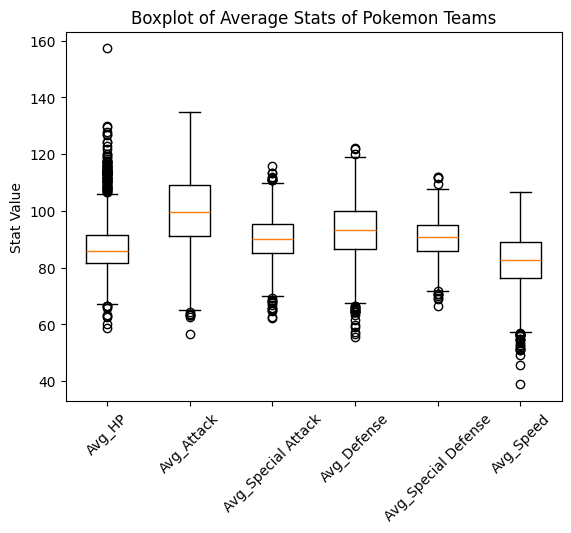

In [146]:
plots = ['Avg_HP', 'Avg_Attack', 'Avg_Special Attack', 'Avg_Defense', 'Avg_Special Defense', 'Avg_Speed']

plt.boxplot([showdown_df[plot].dropna() for plot in plots], tick_labels=plots)
plt.title("Boxplot of Average Stats of Pokemon Teams")
plt.xticks(rotation=45)
plt.ylabel("Stat Value")
plt.show()

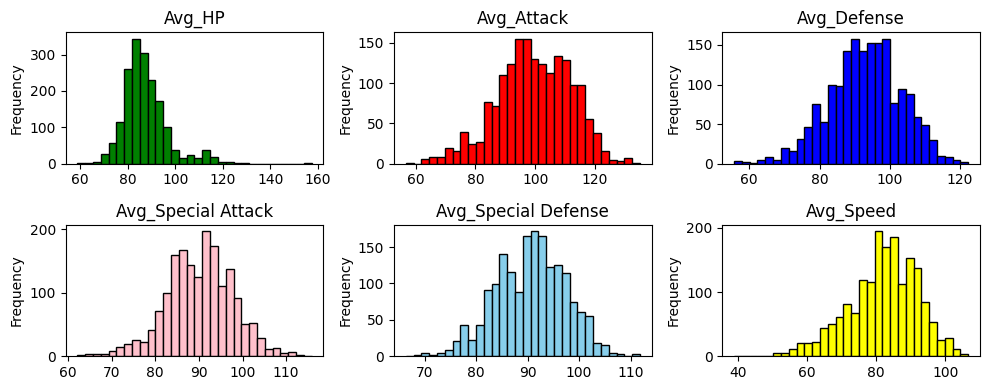

In [147]:
fig, ax = plt.subplots(2, 3, figsize=(10, 4))

ax[0,0].hist(showdown_df['Avg_HP'],bins=30, color='green', edgecolor='black')
ax[0,0].set_title('Avg_HP')
ax[0,0].set_ylabel('Frequency')

ax[0,1].hist(showdown_df['Avg_Attack'],bins=30, color='red', edgecolor='black')
ax[0,1].set_title('Avg_Attack')
ax[0,1].set_ylabel('Frequency')

ax[0,2].hist(showdown_df['Avg_Defense'],bins=30, color='blue', edgecolor='black')
ax[0,2].set_title('Avg_Defense')
ax[0,2].set_ylabel('Frequency')

ax[1,0].hist(showdown_df['Avg_Special Attack'],bins=30, color='pink', edgecolor='black')
ax[1,0].set_title('Avg_Special Attack')
ax[1,0].set_ylabel('Frequency')

ax[1,1].hist(showdown_df['Avg_Special Defense'],bins=30, color='skyblue', edgecolor='black')
ax[1,1].set_title('Avg_Special Defense')
ax[1,1].set_ylabel('Frequency')

ax[1,2].hist(showdown_df['Avg_Speed'],bins=30, color='yellow', edgecolor='black')
ax[1,2].set_title('Avg_Speed')
ax[1,2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Looking at the box plot, the average HP of Pokemon teams has the most severe outlier. On the other hand, the average attack has the biggest interquartile range and whiskers, showing a wide distribution of attack values of each team.

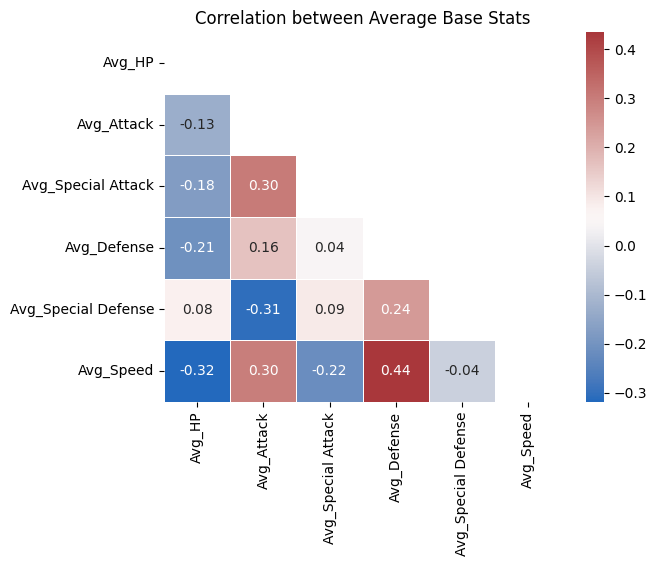

In [148]:
team_stats_df = showdown_df[
    [
        "Avg_HP",
        "Avg_Attack",
        "Avg_Special Attack",
        "Avg_Defense",
        "Avg_Special Defense",
        "Avg_Speed",
    ]
]
team_stats_correlation = team_stats_df.corr()
ax = sns.heatmap(
    team_stats_correlation,
    mask=np.triu(team_stats_correlation),
    annot=True,
    fmt = ".2f",
    linewidth=0.5,
    cmap="vlag"
)
plt.title("Correlation between Average Base Stats")
plt.show()

Based on the Pearson correlation of the average base stats of Pokemon teams, we can see that there is a moderate positive correlation between special attack and attack, speed and attack, and defense and speed.
From this, can infer that Pokemon with a high attack value can be expected to have a moderately high amount of special attack, and/or speed. What we did not expect is that Pokemon teams with high defense also have high speed.

Regarding the negative correlations, what we can see is that HP and speed have a moderately negative correlation, just like attack and special defense. This would make sense as that means teams with high HP would have a lower speed stat.
Pokemon teams with high attack also have a down side of lowered special defense.

### 4.2 Lead Pokemon

#### 4.2.1 Mode of Lead Pokemon

Another thing we would like to observe is which Pokemon is brought
out first. For this, we will use a bar graph and get the mode.

<Axes: xlabel='LeadPokemon'>

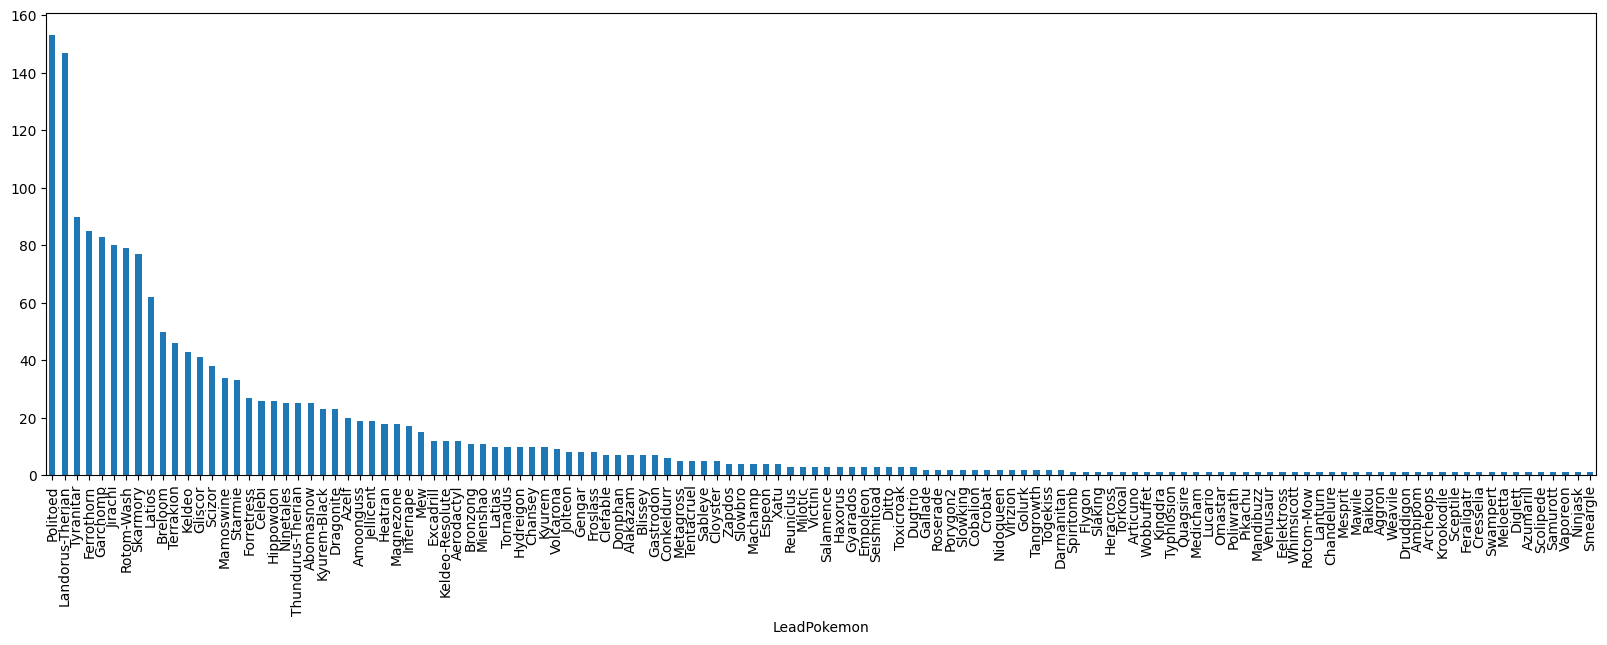

In [149]:
showdown_df["LeadPokemon"].value_counts()
showdown_df["LeadPokemon"].value_counts().plot(kind="bar", figsize=(20, 6))

In [150]:
showdown_df["LeadPokemon"].value_counts()

LeadPokemon
Politoed            153
Landorus-Therian    147
Tyranitar            90
Ferrothorn           85
Garchomp             83
                   ... 
Scolipede             1
Samurott              1
Vaporeon              1
Ninjask               1
Smeargle              1
Name: count, Length: 126, dtype: int64

As seen in the graph and the counts, most players choose to use Politoed
as their lead Pokemon, closely followed by Landorus-Therian, with the following
choices being at least 38.8% less frequently used.

#### 4.2.2 Lead Pokemon stat distribution

We also wanted to view the distribution of the stats
of each lead Pokemon in order to understand if the stats of a Pokemon
play a factor in why it is chosen as the lead.

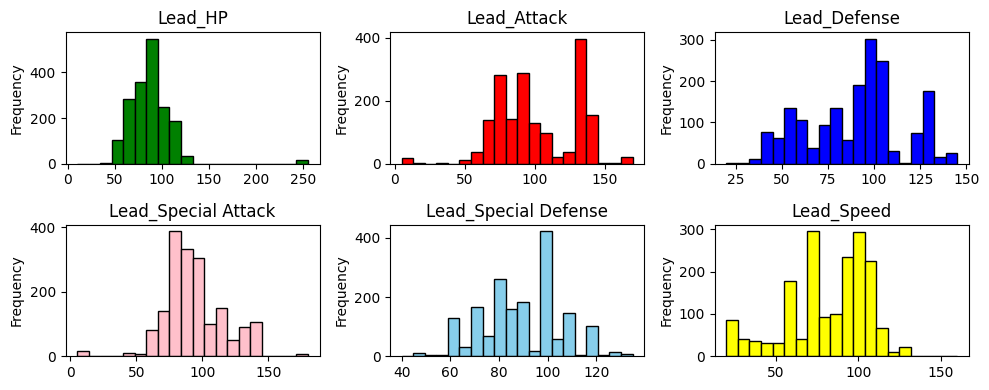

In [151]:
fig, ax = plt.subplots(2, 3, figsize=(10, 4))

ax[0,0].hist(showdown_df['Lead_HP'],bins=20, color='green', edgecolor='black')
ax[0,0].set_title('Lead_HP')
ax[0,0].set_ylabel('Frequency')

ax[0,1].hist(showdown_df['Lead_Attack'],bins=20, color='red', edgecolor='black')
ax[0,1].set_title('Lead_Attack')
ax[0,1].set_ylabel('Frequency')

ax[0,2].hist(showdown_df['Lead_Defense'],bins=20, color='blue', edgecolor='black')
ax[0,2].set_title('Lead_Defense')
ax[0,2].set_ylabel('Frequency')

ax[1,0].hist(showdown_df['Lead_Special Attack'],bins=20, color='pink', edgecolor='black')
ax[1,0].set_title('Lead_Special Attack')
ax[1,0].set_ylabel('Frequency')

ax[1,1].hist(showdown_df['Lead_Special Defense'],bins=20, color='skyblue', edgecolor='black')
ax[1,1].set_title('Lead_Special Defense')
ax[1,1].set_ylabel('Frequency')

ax[1,2].hist(showdown_df['Lead_Speed'],bins=20, color='yellow', edgecolor='black')
ax[1,2].set_title('Lead_Speed')
ax[1,2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Looking at the distribution of lead Pokemon stats, the values are more spread out. The HP stat is still the one with big outliers and we can view this better, including the different measures of dispersion.

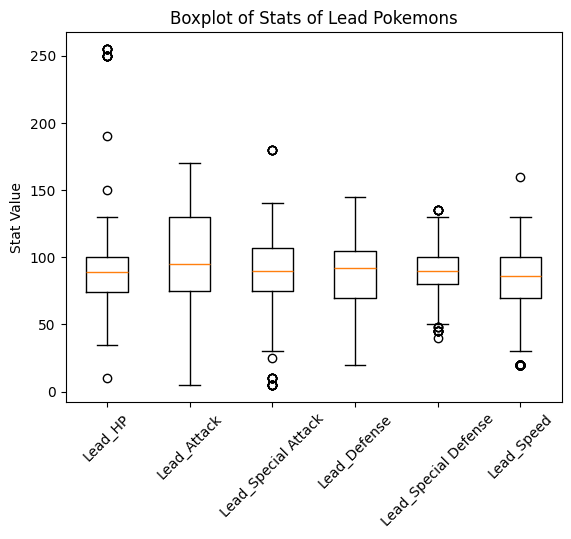

In [152]:
plots = ['Lead_HP', 'Lead_Attack', 'Lead_Special Attack', 'Lead_Defense', 'Lead_Special Defense', 'Lead_Speed']

plt.boxplot([showdown_df[plot].dropna() for plot in plots], tick_labels=plots)
plt.title("Boxplot of Stats of Lead Pokemons")
plt.xticks(rotation=45)
plt.ylabel("Stat Value")
plt.show()

As we can see, some Pokemon brought out as leads have an absurdly high amount of HP compared to the rest while Attack still has the biggest interquartile range.

### 4.3 Elo and Turncount

Another interesting set of statistics to explore is Elo and Turncount. Elo is
is the main ladder rating that dictates a player's position in the format. 
A higher ELO constitutes to a higher ranking in the ladder, and generally indicates a higher skill level. 
TurnCount on the other hand simply measures the amount of turns it took to finish the game.

#### 4.3.1 Mean and Median of Elo and Turn Count

In [153]:
elo_turncount_df = showdown_df[['Elo', 'TurnCount']]

In [154]:
elo_turncount_df.agg(['mean', 'median'])

,Elo,TurnCount
mean,1383.954749,29.005587
median,1368.000000,24.000000


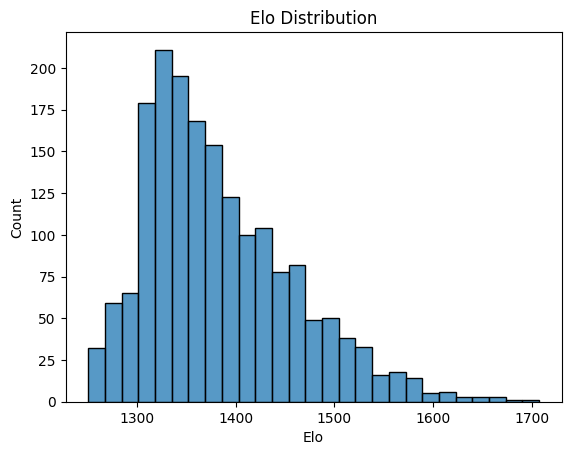

In [155]:
sns.histplot(elo_turncount_df['Elo'])
plt.title("Elo Distribution")
plt.show()

Based off the histogram, the elo distribution looks positively skewed.

But for a more quantifiable analysis, we conduct a Shapiro-Wilk test for normality.

* $H_0$: The data is normally distributed
* $H_a$: The data is not normally distributed

We set a significance level of $a = 0.05$.

In [156]:
statistic, p_value = sp.shapiro(elo_turncount_df['Elo'])

print(f"{p_value = }")

p_value = np.float64(6.169603471297848e-25)


With a p-value of around $4.06 \times 10^{-35} (< a = 0.05)$,
we reject $H_0$, i.e, elo is not normally distributed.

From the graph, ELO is right skewed because generally most players dont break 1400 ELO count and fewer players maintain a high ELO rating.

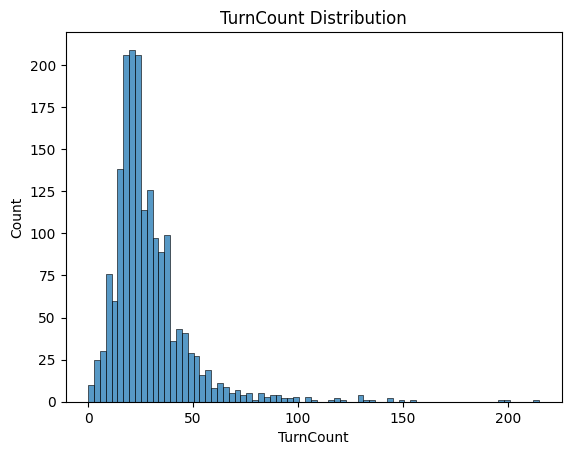

In [157]:
sns.histplot(elo_turncount_df['TurnCount'])
plt.title("TurnCount Distribution")
plt.show()

The turncount distribution appears positively skewed as well;
we again conduct a test for normality:

In [158]:
statistic, p_value = sp.shapiro(elo_turncount_df['TurnCount'])
print(f"{p_value = }")

p_value = np.float64(1.3193500384896357e-45)


With a p-value of around $1.55 \times 10^{-64} (< a = 0.05)$, we
reject $H_0$, i.e, turncount is not normally distributed.

Most games observed run normally between 0 and 50 turns, but there are extreme cases where one of the players run a stall team prolonging the game. A stall team is a team that aims to outlive the opponent by healing though damage, inflicting status conditions like paralysis and by lowering the stats of opposing pokemon.

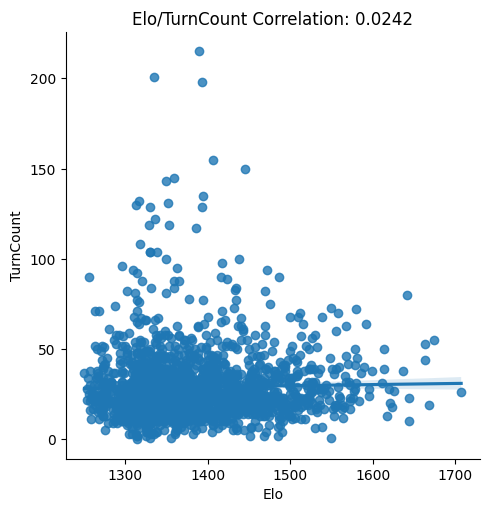

In [159]:
corr = elo_turncount_df.corr()['Elo']['TurnCount']
ax = sns.lmplot(x='Elo', y='TurnCount', data=elo_turncount_df)
plt.title(f"Elo/TurnCount Correlation: {corr:.4f}")
plt.show()

It would appear that there is very little correlation between elo and turncount. This proves that games within high ELO's are not guarranteed to be longer or shorter.

### 4.4 Pokemon Types

As mentioned pokemon typing is crucial in building teams, as such an intriguing detail to look into is the frequency of inclusions of a pokemon type to a type to see if a type would be more dominant in teambuilding than others



#### 4.4.1 Total matches

A new data frame is instantiated for the purposes of this section, that which would contain the total matches, and the sum of all wins, loses and ties for each type.

In [160]:
types = ['Normal', 'Fighting','Flying','Poison','Ground','Rock','Bug','Ghost','Steel',
         'Fire','Water','Grass','Electric','Psychic','Ice','Dragon','Dark'
]

results = ['win', 'lose', 'tie', 'total']

gen5_type_winrate_df = pd.DataFrame({'Type': types})
for result in results:
    gen5_type_winrate_df[result] = 0
    
gen5_type_winrate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Type    17 non-null     object
 1   win     17 non-null     int64 
 2   lose    17 non-null     int64 
 3   tie     17 non-null     int64 
 4   total   17 non-null     int64 
dtypes: int64(4), object(1)
memory usage: 812.0+ bytes


In [161]:
for row in showdown_df.itertuples():
    for type in types:
        if (showdown_df.at[row.Index, f'Has_{type}']):
            result = showdown_df.at[row.Index, 'Result']
            gen5_type_winrate_df.loc[gen5_type_winrate_df['Type'] == type, result] += 1
            gen5_type_winrate_df.loc[gen5_type_winrate_df['Type'] == type, 'total'] += 1

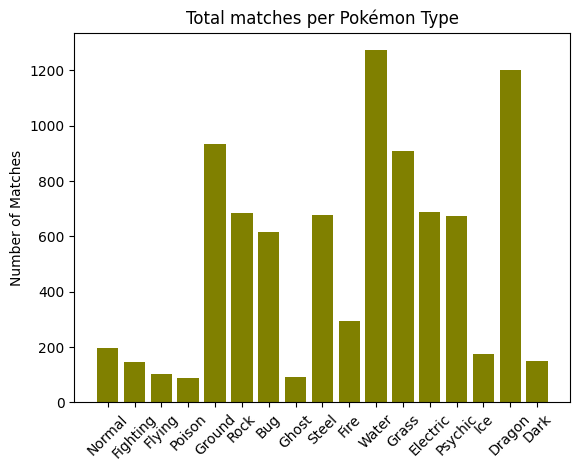

In [162]:
plt.bar(gen5_type_winrate_df['Type'], gen5_type_winrate_df['total'], color='olive')

plt.ylabel('Number of Matches')
plt.title('Total matches per Pokémon Type')
plt.xticks(rotation=45)
plt.show()

As seen in the bar plot above, the two types prefered to bring are Water and Dragon types.



#### 4.4.2 Win/Lose rate

For the following section, the sum of wins, loses and ties are utilized to form columns for the percentage of the results.

In [163]:
for row in gen5_type_winrate_df.itertuples():
    for result in results:
        wins = gen5_type_winrate_df.loc[row.Index, 'win']
        loses = gen5_type_winrate_df.loc[row.Index, 'lose']
        ties = gen5_type_winrate_df.loc[row.Index, 'tie']
        total = gen5_type_winrate_df.loc[row.Index, 'total']
        
        gen5_type_winrate_df.loc[row.Index, 'win%'] = wins / total * 100
        gen5_type_winrate_df.loc[row.Index, 'lose%'] = loses / total * 100
        gen5_type_winrate_df.loc[row.Index, 'tie%'] = ties / total * 100
        

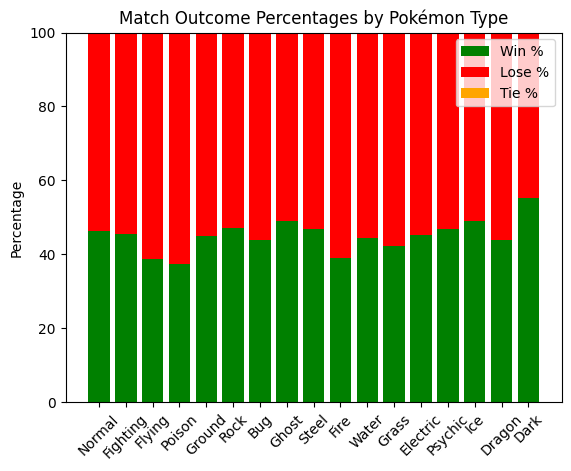

In [164]:
plt.bar(gen5_type_winrate_df['Type'], gen5_type_winrate_df['win%'], label='Win %', color='green')
plt.bar(gen5_type_winrate_df['Type'], gen5_type_winrate_df['lose%'], bottom=gen5_type_winrate_df['win%'], label='Lose %', color='red')
plt.bar(gen5_type_winrate_df['Type'], gen5_type_winrate_df['tie%'], bottom=gen5_type_winrate_df['win%'] + gen5_type_winrate_df['lose%'], label='Tie %', color='orange')

plt.ylabel('Percentage')
plt.title('Match Outcome Percentages by Pokémon Type')
plt.legend()
plt.xticks(rotation=45)
plt.show()

Observing the graph would give us the impression that all the Pokemon types are middling in win rate, with no specific type breaking the 60% win rate and merely staying below it.